In [97]:

# Jupyterでmatplotlibを使用する宣言と、使用するライブラリの定義
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
# 動画の描画関数の宣言
# 参考URL http://nbviewer.jupyter.org/github/patrickmineault
# /xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from matplotlib import animation
from IPython.display import display
from IPython.display import HTML
 
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
 
    def animate(i):
        patch.set_data(frames[i])
 
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)
 
    anim.save('movie_cartpole.mp4')  # 追記：動画の保存です
    #display(display_animation(anim, default_mode='loop'))
    #HTML(anim.to_html5_video())
    return anim

続いて、今回使用する定数を以下のように定義します。MAX_STEPSは1試行の最大ステップ数です。CartPole-v0の場合は200step立ち続ければゲーム攻略となるので200としています。NUM_EPISODESは最大の試行回数です。今回は1000と設定し、この試行数以内にゲームの攻略を目指します。
Episode Termination
Pole Angle is more than ±12°
Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
Episode length is greater than 200 (500 for v1).

カート位置（-2.4～2.4）
カート速度（-Inf～Inf）
棒の角度（-41.8°～41.8°）
棒の角速度（-Inf～Inf）
の4変数で表されます[1]。カッコ内の数字はそれぞれの変数がとりうる範囲を示しており、これらの4変数は連続値となります。CartPole課題は迷路とは異なり、状態を表す変数が複数存在し、さらにそれぞれ連続値をとる点が難しい原因です。

このようなCartPoleの状態に対して、迷路と同じようにQ関数を表形式で表現します。そのためには連続値を離散化する必要があります。例えばカートの位置を6つの値(0～5)で離散化する場合には、位置が-2.4～-1.6の場合は0、-1.6～-0.8は1、-0.8～0.0は2、・・・、1.6～2.4は5という値に変換します。ただし、端に行き過ぎた瞬間などには-2.4を越えた位置に行く可能性もあるので、-Inf～-1.6を0とし、1.6～Infを5とします。すると連続値だったカートの位置は0～5の6つの数字で表されます。他の変数も同様に6つの値で離散化する場合、変数が4種類あるので、64=1296通りで、CartPoleの状態が表されます。つまり迷路に例えると、マスが1296個あるイメージです。

CartPoleの行動は、カートを右に押す、カートを左に押すの2通りです。カートに対して右か左に加速度を与える操作を行います。

よって、CartPoleのQ関数は各状態を6つの値で離散化したとすれば、1296行×2列の表形式で表すことができます。迷路のときと同様に表の中の値は、各状態で各行動を採用した際にその後得られるであろう割引報酬和を示します。これでCartPole課題でも迷路のときと同じようにQ関数を表形式で表すことができます。

CartPole課題におけるQ学習の実装

今回の実装からクラスを定義して実装します。今回実装するクラスはAgent、Brain、Environmentの3つです。AgentはCartPole課題の場合、棒付き台車そのものです。そしてAgentは周囲の状態に合わせて、自分のQ関数を更新する関数update_q_functionと、次の行動を決定する関数get_actionを持ちます。BrainはAgentの頭脳となる部分です。Brainに今回はQテーブルを用いたQ学習を実装します。BrainはAgentが観測した周囲の状態を離散化する関数digitize_stateと、Qテーブルを更新する関数update_Qtable、Qテーブルから行動を決定する関数decide_actionを持ちます。今回AgentとBrainにクラスを分けたのは、今後Q学習をSarsaに変更したりDeepLearningを用いた手法に変更したりする際に、このBrainクラスだけを変更すれば良いようにする意図があります。EnvironmentはOpenAI gymの実行環境です。今回はCartPoleを実行する環境であり、実行関数runを持ちます。



Agentが持つ頭脳となるクラスBrainを定義します。今回はQ学習を実装しています。少し長くて難しそうですが、やっていることは単純です。

関数binsとdigitize_stateを用いて、4変数の連続状態を1296通りの離散値へと変換しています。関数binsでnp.linspaceのあとに[1:-1]がついているのは、離散化する際に端を-InfとInfに設定するためです。関数digitize_stateにおいて、pole_angleを-0.5から0.5で離散化しているのは、この変数がプログラム内では[radian]で表されているからです。0.5[radian] = 約29[°]となります。関数digitize_stateのreturnの部分は一見難しそうですが、離散化された状態をNUM_DIZITIZED=6の場合には6進数で表現しています。例えば、　カート位置, カート速度, 棒の角度, 棒の角速度）＝（1, 2, 3, 4）　だった場合には、

1 ∗ 60 + 2 ∗ 61 + 3 ∗ 62 + 4 ∗ 63 = 985

となり、状態985と定義されます。

Qテーブルの更新方法は迷路課題のときと同様です。行動の決定は試行数が少ないときは探索行動が多くなるようにε-greedy法としています。この部分の実装には引用[2]も参考にさせていただきました。

In [111]:

# エージェントが持つ脳となるクラスです、Q学習を実行します
class Brain:
 
    def __init__(self, num_states, num_actions):
        self.num_states = num_states  # CartPoleは状態数4を取得
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得
        # 状態を分割数^（4変数）にデジタル変換したQ関数（表）を作成
        self.q_table = np.random.uniform(low=0, high=1, size=(NUM_DIZITIZED**self.num_states, self.num_actions))
 
 
    def bins(self, clip_min, clip_max, num):
        #観測した状態（連続値）を離散値にデジタル変換する
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]
 
    def digitize_state(self, observation):
        # 観測したobservation状態を、離散値に変換する
        # observationは4つの連続した変数からなる
        # NUM_DIZITIZEDは各変数を離散化する分割数
        # 例えば、observation[0]はカートの位置で、連続値であるが、
        # これを、[-2.4, -1.8, ..., 2.4]の離散値に変換する
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
        np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
        np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
        np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
        np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])
 
    def update_Qtable(self, observation, action, reward, observation_next):
        # QテーブルをQ学習により更新
        # 観測を離散化
        state = self.digitize_state(observation)
        state_next = self.digitize_state(observation_next)
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])
 
    def decide_action(self, observation, episode):
        # ε-greedy法で徐々に最適行動のみを採用する
        state = self.digitize_state(observation)
        #epsilon = EPSILONINI * (1 / (episode + 1))
        epsilon = EPSILONINI * (DECAY ** episode)
 
        if epsilon <= np.random.uniform(0, 1):
            # 最も良い行動を返す
            action = np.argmax(self.q_table[state][:])
        else:
            # 0,1の行動をランダムに返す
            action = np.random.choice(self.num_actions)
        return action

次にAgentクラスを定義します。Agentクラスはコンストラクタ（init）でCartPoleの状態変数の数と行動の種類数を格納します。また自身の頭脳となるBrainクラスを生成します。さきほど説明した通り、Q関数の更新と行動の決定をBrainクラスを通じて実行するメソッドを持ちます。

In [112]:

# CartPoleで動くエージェントクラスです、棒付き台車そのものになります
class Agent:
    def __init__(self, num_states, num_actions):
        # 課題の状態と行動の数を設定
        self.num_states = num_states     # CartPoleは状態数4を取得
        self.num_actions = num_actions        # CartPoleの行動（右に左に押す）の2を取得
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための脳を生成
 
    def update_q_function(self, observation, action, reward, observation_next):
        # Q関数の更新
        self.brain.update_Qtable(observation, action, reward, observation_next)
 
    def get_action(self, observation, step):
        # 行動の決定
        action = self.brain.decide_action(observation, step)
        return action

最後のクラスであるEnvironmentを定義します。今回は10回連続で195step以上立ち続ければ強化学習成功とし、動画を保存のためにもう1回実行してしています。self.env = gym.make(ENV)で、実施する課題を設定しています。self.env.observation_space.shape[0]は課題が持つ状態変数の数を示します。self.env.action_space.nは課題が持つ行動の数を示します。

OpenAI Gymを実行する際に、各試行の最初に以下の命令observation = self.env.reset()を実行する必要があります。observationには状態を表す変数の値が格納されます。

observation_next, reward_notuse, done, info_notuse = self.env.step(action)　は、actionを実行するメソッドです。その結果、実行後の次のステップでの状態observation_nextと、元々CartPole-v0で決められているルールでの報酬、実行終了フラグであるdone、その他情報のinfoが出力されます。doneは200step経過するか、棒が20.9度以上傾いたり、カート位置が±2.4の範囲外まで移動するとTrueとなります。今回はこの関数で出力される報酬と情報は使用しないので、notuseを記載しています。

episode_finalは、10試行連続で成功した場合にTrueとなるフラグです。episode_finalがTrueの試行では各stepでの画像をframesに格納していき、最後に動画を保存・再生します。

In [130]:

# CartPoleを実行する環境のクラスです
class Environment:
 
    def __init__(self):
        self.env = gym.make(ENV, render_mode="rgb_array") # 実行する課題を設定
        self.env.reset()
        self.num_states = self.env.observation_space.shape[0]  # 課題の状態と行動の数を設定
        self.num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(self.num_states, self.num_actions)  # 環境内で行動するAgentを生成
 
    def run(self):
        # 実行
 
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        episode_final = False  # 最後の試行フラグ
        self.steparived = [] 
 
 
        for episode in range(NUM_EPISODES):
        # 試行数分繰り返す
            observation = self.env.reset()[0]  # 環境の初期化
            episode_reward = 0  # エピソードでの報酬
            
            # 1エピソードのループ
            for step in range(MAX_STEPS+1):
 
                if episode_final is True:
                    # framesに各時刻の画像を追加していく
                    frames.append(self.env.render())
 
                action = self.agent.get_action(observation, episode)  # 行動を求める episodeはget_actionのε-greedyのために使用 obsevationは状態s_tを取得
 
                # 行動a_tの実行により、s_{t+1}, r_{t+1}を求める
                #observation_next, reward_notuse, done, info_notuse = self.env.step(action)
                observation_next, reward_notuse, done, trancated, info_notuse = self.env.step(action)
                
                if step == MAX_STEPS: done = True
                # 報酬を与える
                if done:  # ステップ数が200(or 500)経過するか、一定角度以上傾くとdoneはtrueになる
                    
                    if step < MAX_STEPS-5:
                        reward = -1  # 途中でこけたら罰則として報酬-1を与える
                        self.complete_episodes = 0
                    else:
                        reward = 5  # 立ったまま終了時は報酬1を与える
                        self.complete_episodes = self.complete_episodes + 1  # 連続記録を更新
                else:
                    reward = 0
 
                episode_reward += reward  # 報酬を追加
 
                # step+1の状態observation_nextを用いて,Q関数を更新する
                self.agent.update_q_function(
                    observation, action, reward, observation_next)
 
                # 観測の更新
                observation = observation_next
 
                # 終了時の処理
                if done:
                    self.steparived.append(step)
                    if episode%100 == 0: print('{0} Episode: Finished after {1} time steps'.format(episode, step+1))
                    break
 
            if episode_final is True:
                # 動画の保存と描画
                print('Finished')
                self.anim = display_frames_as_gif(frames)
                #HTML(self.anim.to_html5_video())
                break
 
            if self.complete_episodes >= 100:
                print('連続成功')
                frames = []
                episode_final = True  # 次の試行を描画を行う最終試行とする


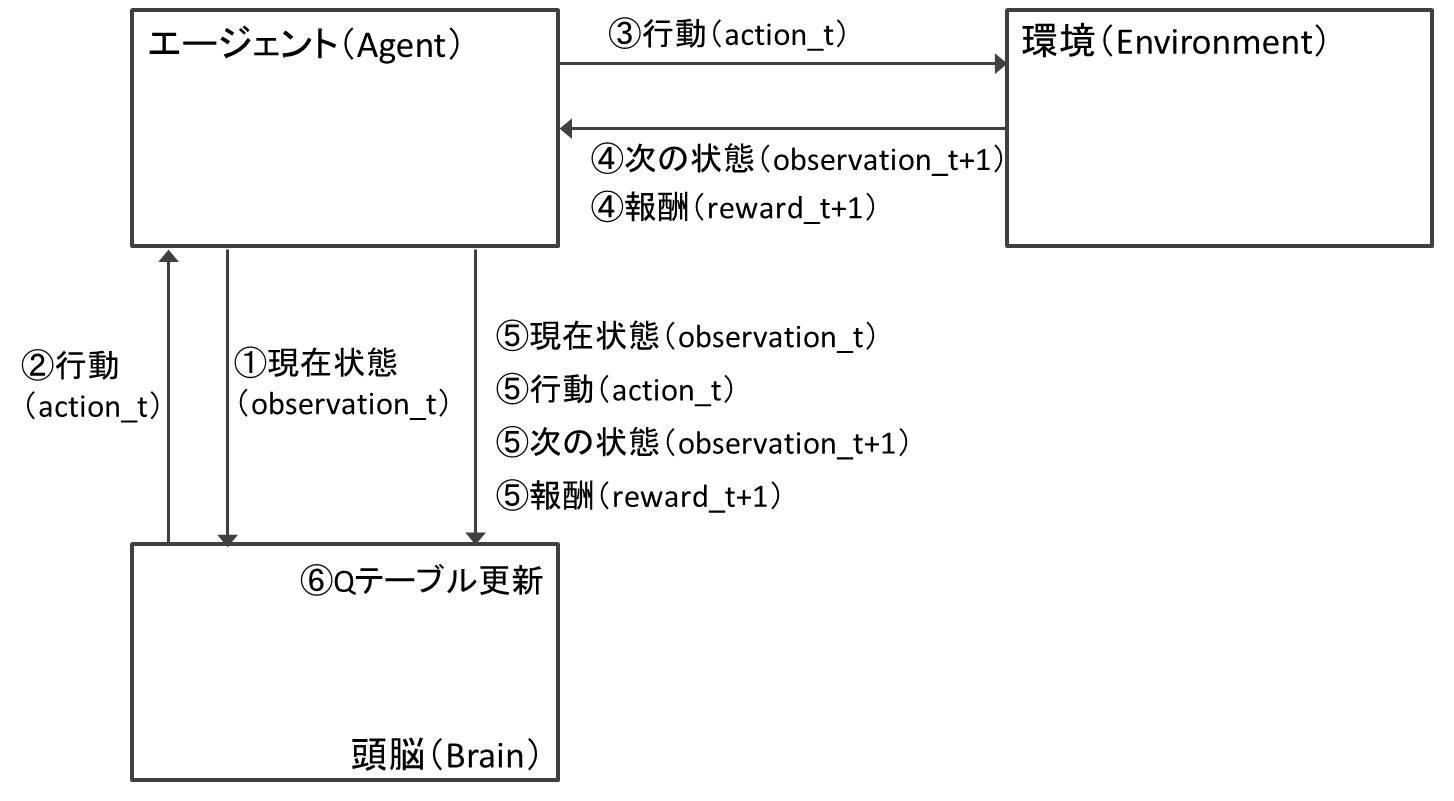

In [131]:
# pillowをインポート
from PIL import Image
# 画像パス
filename = "./cartpole_class.jfif"
# Pillowで開く
im = Image.open(filename)
# 表示
im

In [132]:
# 定数の設定
ENV = 'CartPole-v1'  # 使用する課題名
 
NUM_DIZITIZED = 6  # 各状態の離散値への分割数
GAMMA = 0.99  # 時間割引率
ETA = 0.4 # 学習係数
EPSILONINI = 0.5  # random ratio
DECAY = 0.99  # epsilon decay rate
 
MAX_STEPS = 500  # 1試行のstep数
NUM_EPISODES = 10000  # 最大試行回数

c:\Users\ikemix\anaconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0 Episode: Finished after 8 time steps
100 Episode: Finished after 108 time steps
200 Episode: Finished after 12 time steps
300 Episode: Finished after 51 time steps
400 Episode: Finished after 159 time steps
500 Episode: Finished after 246 time steps
600 Episode: Finished after 226 time steps
700 Episode: Finished after 189 time steps
800 Episode: Finished after 171 time steps
900 Episode: Finished after 501 time steps
1000 Episode: Finished after 501 time steps
1100 Episode: Finished after 501 time steps
1200 Episode: Finished after 501 time steps
1300 Episode: Finished after 501 time steps
1400 Episode: Finished after 501 time steps
1500 Episode: Finished after 501 time steps
1600 Episode: Finished after 501 time steps
1700 Episode: Finished after 501 time steps
1800 Episode: Finished after 501 time steps
1900 Episode: Finished after 501 time steps
2000 Episode: Finished after 501 time steps
2100 Episode: Finished after 501 time steps
10回連続成功
Finished


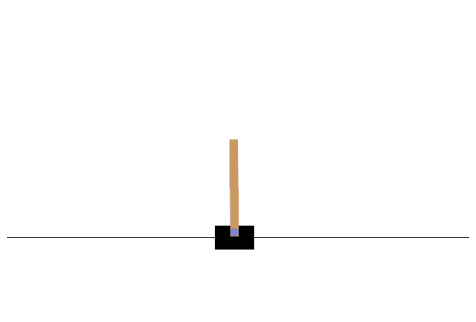

In [133]:
# main クラス
cartpole_env = Environment()
cartpole_env.run()


import matplotlib.pyplot as plt

def plot_result(scores):
    # 直近100エピソードの報酬の平均およびそのばらつき(標準偏差)を計算
    mean = []
    std = []
    for i in range(len(scores)):
        if i < 100:
            mean.append(sum(scores[:i+1])/(i+1))
            std.append(0)
        else:
            mean.append(sum(scores[i-99:i+1])/100)
            std.append(np.std(scores[i-99:i+1], ddof=1))
    # グラフ描画
    plt.plot(mean)
    plt.fill_between(range(len(mean)), np.array(mean)-np.array(std), np.array(mean)+np.array(std), alpha=0.1)
    plt.show()
#plot_result(cartpole_env.steparived)
HTML(cartpole_env.anim.to_html5_video())

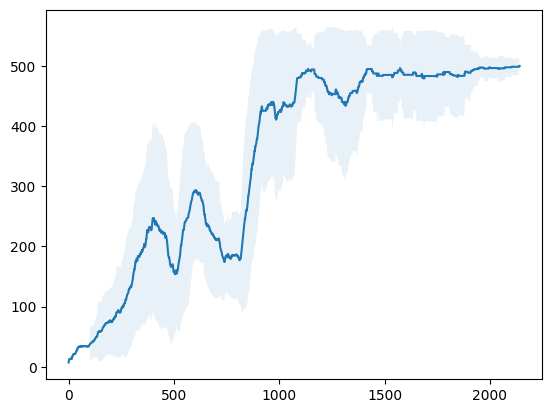

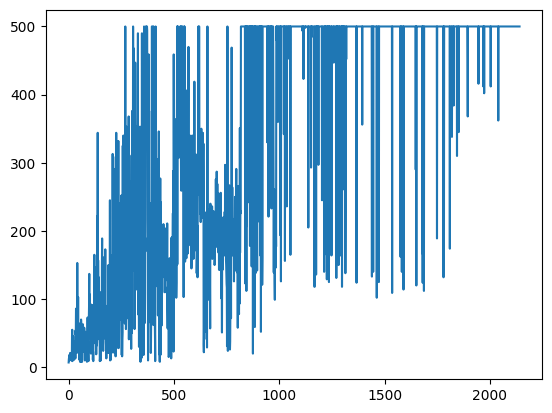

In [134]:
plot_result(cartpole_env.steparived)
plt.plot(cartpole_env.steparived)
plt.show()

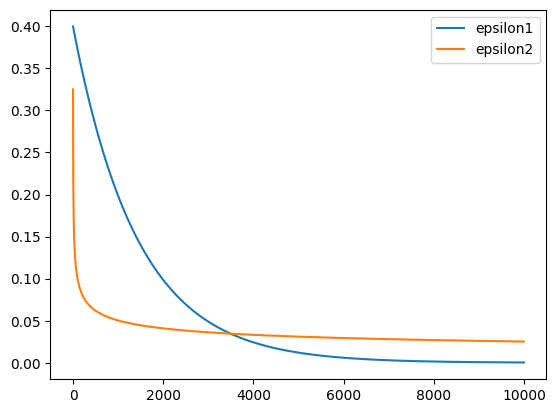

In [79]:
# epsilonの変化
import numpy as np
import matplotlib.pyplot as plt
import random
epls1 = []
epls2 = []
for episode in range(1, 10000):
    epsilon1 = 0.4 * (0.999 ** episode)
    epsilon2 = 0.4 * (1 / (episode + 1))**0.3
    epls1.append(epsilon1)
    epls2.append(epsilon2)

plt.plot(epls1, label='epsilon1')
plt.plot(epls2, label='epsilon2')
plt.legend()
plt.show()